In [1]:
import pandas as pd
import re, math
import seaborn as sns
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pprint import pprint

pd.options.display.float_format = "{:,.2f}".format

sns.set_theme(style='whitegrid')

# Config Session

In [2]:
PATH_RULES = 'data/rules.json'

PROTEINS = {
    1: 'CARNES',
    2: 'CARNES ULTRAPROCESSADAS',
    3: 'PESCADOS',
    4: 'OVOS',
    5: 'SUBSTITUTOS DE CARNE'
}

CODES = {
    11: 'CARNE BOVINA',
    12: 'CARNE SUINA',
    13: 'OUTRAS CARNES',
    14: 'AVES',
    15: 'CARNES SECAS E SALGADAS',
    16: 'VÍSCERAS',
    17: 'PREPARAÇÕES QUE INCLUEM CARNES BOVINAS',
    17: 'PREPARAÇÕES QUE INCLUEM OUTRAS CARNES',
    21: 'ALMÔNDEGAS, HAMBURGERS E NUGGETS',
    22: 'EMBUTIDOS, FRIOS E CONSERVAS',
    23: 'PREPARAÇÕES QUE INCLUEM CARNES UP',	
    31: 'PESCADOS FRESCOS',
    32: 'PESCADOS EM CONSERVA',
    33: 'PESCADOS SALGADOS',
    34: 'PREPARAÇÕES QUE INCLUEM PESCADOS',
    41: 'OVOS INTEIROS',
    42: 'REFEIÇÕES QUE INCLUEM OVOS',
    51: 'PTS - CARNE DE SOJA',
    52: 'PREPARAÇÕES QUE INCLUEM CARNE DE SOJA'
}

CORTES = {
    111: 'CORTE TRASEIRO',
    112: 'CORTE DIANTEIRO'
}

VIS_FIELDS = [
    'ano',
	'item',
	'un',
	'qt',
	'valor_un',
	'valor',
	'valor_real',
	'produtos',
	'un_adj',
    'is_outlier_valor_un',
    'is_outlier_qt',
    'quartile_range_valor_un',
    'quartile_range_qt'
]



# Input Data

In [3]:
df_units_products = pd.read_csv('data/stat_unidades_por_produto.csv')
df_dataset_beef = pd.read_parquet('data/banco_carnes_un.parquet')

df_dataset_beef['has_change'] = 0
df_dataset_beef['unit_kg'] = 0
df_dataset_beef['price_kg'] = 0
df_dataset_beef['rule_apply'] = 0
df_dataset_beef['outlier'] = 0

with open(PATH_RULES, 'r') as f: rules = json.load(f)

# Helpers

In [4]:
def count_without_outliers(df, group_by_columns, value_column):
    def remove_outliers(group):
        Q1 = group[value_column].quantile(0.25)
        Q3 = group[value_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[value_column] >= lower_bound) & (group[value_column] <= upper_bound)]

    filtered_df = df.groupby(group_by_columns, group_keys=False).apply(remove_outliers)
    return filtered_df

def set_outlier_property(df, col):
    def classify_quartile(value, q1, q3):
        q1_q2 = (q1 + q3) / 2
        if value <= q1:
            return f'Q1 (<= {q1:.1f})'
        elif q1 < value <= q1_q2:
            return f'Q1-Q2 ({q1:.1f} - {q1_q2:.1f})'
        elif q1_q2 < value <= q3:
            return f'Q3-Q4 ({q1_q2:.1f} - {q3:.1f})'
        else:
            return f'Q4 (> {q3:.1f})'

    q1 = df[col].quantile(0.10)
    q3 = df[col].quantile(0.95)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df[f'is_outlier_{col}'] = (~df[col].between(lower_bound, upper_bound)).astype(int)
  
    df[f'quartile_range_{col}'] = df[col].apply(lambda x: classify_quartile(x, q1, q3))
    return df


    ax = sns.boxplot(data=data, x="ano", y=field, **kwargs, showmeans=False, palette="coolwarm", showfliers=True)
    # ax = sns.boxenplot(data=data, x="ano", y="valor_un", palette="coolwarm")

# Detect outliers

In [5]:

# these values will be changed (calculated)
df_dataset_beef.loc[
    (df_dataset_beef['valor_un'].isna()) & 
    (df_dataset_beef['qt'] >= 1) &
    (df_dataset_beef['codigo'] == 41) &
    (df_dataset_beef['un_adj'] == 'DZ'),
    'has_change'
] = 1

# fix nan values in valor_un
df_dataset_beef.loc[
    (df_dataset_beef['valor_un'].isna()) & 
    (df_dataset_beef['qt'] >= 1) &
    (df_dataset_beef['codigo'] == 41) &
    (df_dataset_beef['un_adj'] == 'DZ'),
    'valor_un'
] = df_dataset_beef['valor'].div(df_dataset_beef['qt'])



# detect firsts outliers for qt and valor_un
df_dataset_beef_cls = df_dataset_beef.groupby(['produtos', 'un_adj'], group_keys=False)\
    .apply(lambda group: set_outlier_property(group, 'valor_un'))

df_dataset_beef_cls = df_dataset_beef_cls.groupby(['produtos', 'un_adj'], group_keys=False)\
    .apply(lambda group: set_outlier_property(group, 'qt'))


# Checking records

In [6]:

df_dataset_beef_cls.query('produtos == "OVOS INTEIROS"').groupby(['un_adj', 'quartile_range_qt','is_outlier_qt'])['valor_un'].count()\
	.reset_index().query('is_outlier_qt == 1 and un_adj == "DZ"')

,un_adj,quartile_range_qt,is_outlier_qt,valor_un
60,DZ,Q4 (> 228.0),1,17410


In [7]:

df_dataset_beef_cls.loc[
    (df_dataset_beef_cls['produtos'] == "OVOS INTEIROS") &
    #(df_dataset_beef_cls['is_outlier_valor_un'] == 0) &
    (df_dataset_beef_cls['is_outlier_qt'] == 1) &
    (df_dataset_beef_cls['valor_un'] > 1) &
    (df_dataset_beef_cls['un_adj'] == 'DZ') &
    (df_dataset_beef_cls['qt'] > 0) &
    (df_dataset_beef_cls['item'].str.contains('30', na=False)) &
    (df_dataset_beef_cls['quartile_range_qt'] == 'Q4 (> 228.0)')
].sort_values(by=['valor_un'], ascending=False)



,...1,ano,UF,municipio,dados.fornecedor,dados.CNPJ.CPF,dados.tipo,dados.n_doc,dados.emissao,valor_total_nota_fiscal,...,un_adj,has_change,unit_kg,price_kg,rule_apply,outlier,is_outlier_valor_un,quartile_range_valor_un,is_outlier_qt,quartile_range_qt
6939236,24347,2021,MT,VARZEA GRANDE,S. J. G. PAGANINI - COMERCIO,04.193.497/0001-62,Nota Fiscal Eletrônica,9534.0,2021-03-17,"104,090.40",...,DZ,0,0,0,0,0,1,Q4 (> 9.3),1,Q4 (> 228.0)
7437931,322,2022,RJ,BARRA MANSA,COOPERATIVA DE AGRICULTORES E AGRICULTORAS FAM...,30.248.992/0001-31,Nota Fiscal Eletrônica,2401,2022-05-06,"7,827.90",...,DZ,0,0,0,0,0,0,Q3-Q4 (6.2 - 9.3),1,Q4 (> 228.0)
5891020,16997,2019,CE,MISSAO VELHA,NILSON BENTO DA SILVA,29.186.945/0001-21,Nota Fiscal Eletrônica,38,2019-04-11,"73,519.11",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
6834163,926,2021,ES,IBIRACU,LICITA WEB COMERCIO LTDA,09.583.801/0001-00,Nota Fiscal Eletrônica,7194,2021-05-05,"10,938.92",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
5891029,17006,2019,CE,MISSAO VELHA,NILSON BENTO DA SILVA,29.186.945/0001-21,Nota Fiscal Eletrônica,63,2019-08-13,"59,736.34",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
6630651,4542,2020,BA,PLANALTO,OLIVEIRA SILVA COMERCIO DE FRIOS LTDA,15.315.067/0001-92,Nota Fiscal Eletrônica,10979,2020-05-22,"25,993.35",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
6630654,4545,2020,BA,PLANALTO,OLIVEIRA SILVA COMERCIO DE FRIOS LTDA,15.315.067/0001-92,Nota Fiscal Eletrônica,11194,2020-07-07,"28,264.01",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
6770895,1268,2020,SC,FORQUILHINHA,COMERCIO DE FRUTAS E VERDURAS OURO NEGRO LTDA,32.147.268/0001-47,Nota Fiscal Eletrônica,684,2020-08-27,"6,100.80",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)
6770896,1269,2020,SC,FORQUILHINHA,COMERCIO DE FRUTAS E VERDURAS OURO NEGRO LTDA,32.147.268/0001-47,Nota Fiscal Eletrônica,685,2020-08-27,"6,113.20",...,DZ,0,0,0,0,0,0,Q1-Q2 (3.1 - 6.2),1,Q4 (> 228.0)


# Applying Rules

In [8]:

for rule in rules['ovos_inteiros']:

	filter_condition = rule['filter']
	unit_kg_expression = rule['unit_kg']
	
	filtered_rows = df_dataset_beef_cls.query(filter_condition)
	
	df_dataset_beef_cls.loc[filtered_rows.index, 'unit_kg'] = filtered_rows.eval(unit_kg_expression)


# calculate price/kg
df_dataset_beef_cls.loc[
    (df_dataset_beef_cls['produtos'] == "OVOS INTEIROS") &
    (df_dataset_beef_cls['unit_kg'] != 0),
    'price_kg'
] = df_dataset_beef_cls['valor'].div(df_dataset_beef_cls['unit_kg'])

# check if rule was applied
df_dataset_beef_cls.loc[
	df_dataset_beef_cls['unit_kg'] != 0,
	'rule_apply'
] = 1

# drop fields
df_dataset_beef_cls.drop(['is_outlier_valor_un','quartile_range_valor_un','is_outlier_qt','quartile_range_qt'],axis=1,inplace=True)


Text(0, 0.5, 'Preço/Kg (R$)')

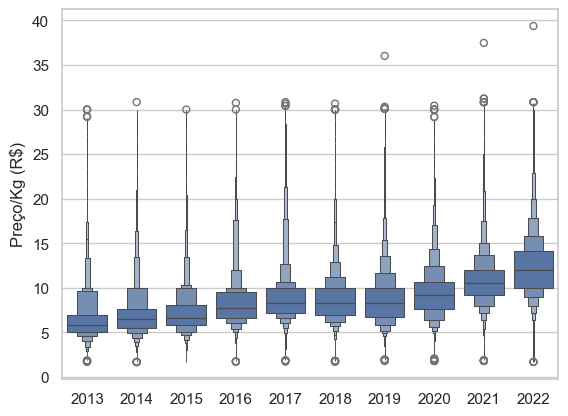

In [9]:
sns.boxenplot(data=df_dataset_beef_cls.loc[
	(df_dataset_beef_cls['produtos'] == "OVOS INTEIROS") &
    (df_dataset_beef_cls['price_kg'] != 0)
], x="ano", y="price_kg")

plt.xlabel('')
plt.ylabel('Preço/Kg (R$)')

# Export Dataset

In [10]:
df_dataset_beef_cls.loc[
    df_dataset_beef_cls['price_kg'] >= 30,
    'outlier'
] = 1

df_dataset_beef_cls.to_parquet('data/banco_carnes_v1.parquet')

# Compute Stat

In [11]:
df_stat_rule = df_dataset_beef_cls.groupby(['produtos','rule_apply']).agg(
    count=('rule_apply', 'count')
).reset_index()



df_stat_rule['percent'] = df_stat_rule['count'] / df_stat_rule.groupby('produtos')['count'].transform('sum') * 100
df_stat_rule.to_csv('data/stat_rule_apply.csv')



In [15]:
df_dataset_beef_cls.loc[
    (df_dataset_beef_cls['codigo'] == 41) & (df_dataset_beef_cls['rule_apply'] == 1)
].groupby('outlier').count()

,...1,ano,UF,municipio,dados.fornecedor,dados.CNPJ.CPF,dados.tipo,dados.n_doc,dados.emissao,valor_total_nota_fiscal,...,codigo,corte,deflator_acum,valor_real,produtos,un_adj,has_change,unit_kg,price_kg,rule_apply
outlier,,,,,,,,,,,,,,,,,,,,,
0,1087994,1087994,1087994,1087994,1087994,1085833,1087994,1087994,1087977,1087994,...,1087994,0,1082455,1087994,1087994,1087994,1087994,1087994,1087994,1087994
1,258,258,258,258,258,258,258,258,258,258,...,258,0,258,258,258,258,258,258,258,258


In [16]:
258/1087994

0.00023713366066356983